In [23]:
import os
import sys
import base64
import matplotlib.pyplot as plt
import numpy as np
from urllib import parse
import pandas as pd

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 
if root_directory not in sys.path:
    sys.path.append(root_directory)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es

In [21]:
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 

In [9]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must": [
        {
          "exists": {
            "field": "topics"
          }
        }
      ]
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

{'took': 558,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1451506, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc', 'doc_count': 1386002},
    {'key': 'ipcc', 'doc_count': 65504},
    {'key': 'ipcc_adaptation', 'doc_count': 43479},
    {'key': 'ipcc_science', 'doc_count': 15250},
    {'key': 'ipcc_mitigation', 'doc_count': 8819}]}}}

Avec topics

In [6]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]#x['doc_count']]
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:   
          data_counts[x['key']].append([bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}


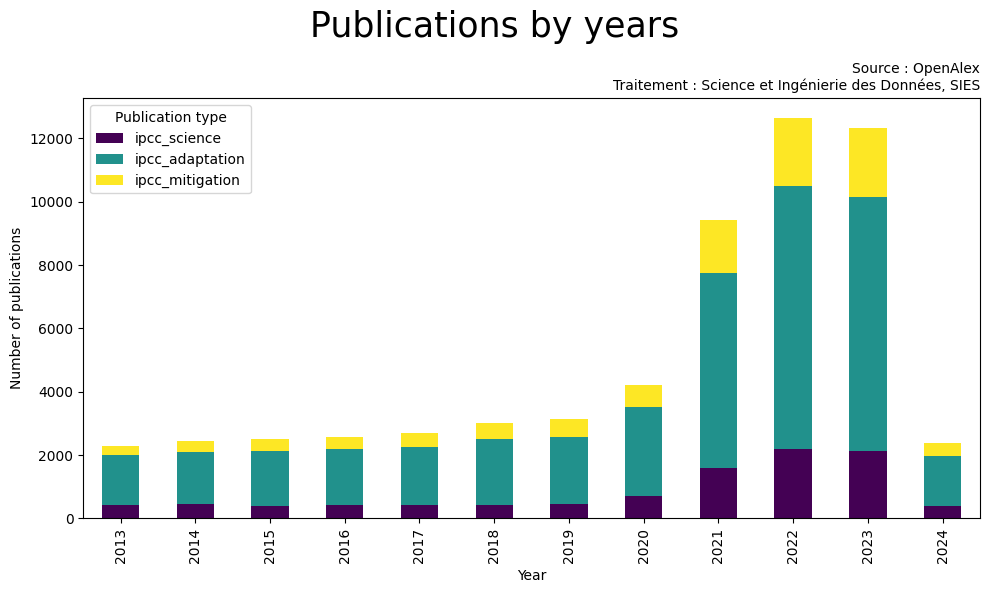

In [7]:
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation', 'ipcc_mitigation'])
df = df.sort_index()
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
ax.set_xlabel('Year')
ax.set_ylabel('Number of publications')
ax.legend(title='Publication type')

plt.suptitle("Publications by years", size=25)
plt.title('Source : OpenAlex\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
plt.tight_layout()
plt.show()

In [8]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    data_counts[x['key']]=[]
    if 'not_ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='not_ipcc'][0]
        data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
    else:
        data_counts[x['key']].append(0)
    if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
        nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
        data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
    else:
        data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0] and value != [100,0]}


C:\Users\haallat\AppData\Local\Temp\ipykernel_5016\3147467221.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=15)


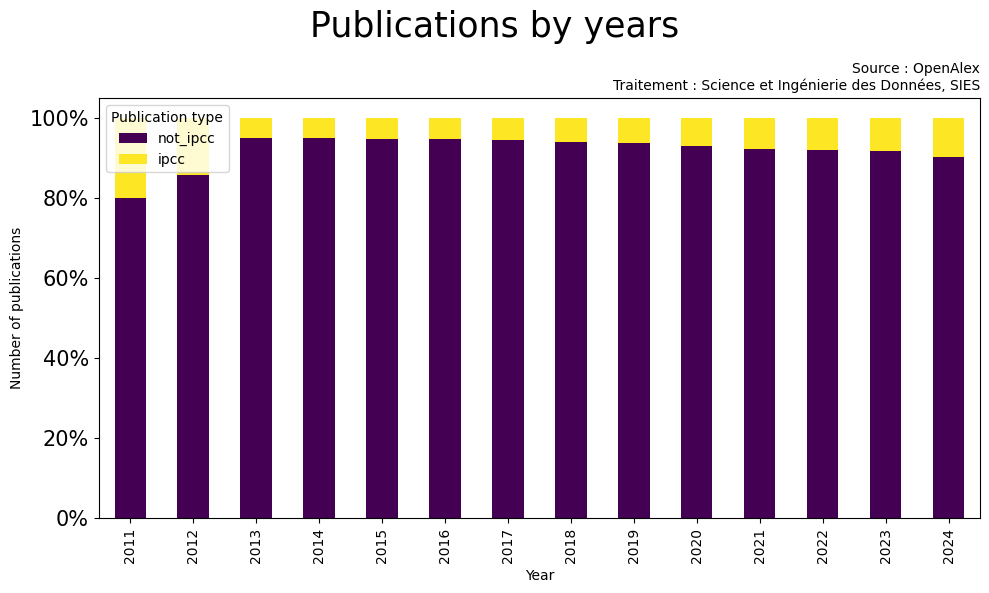

In [9]:
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['not_ipcc', 'ipcc'])
df = df.sort_index()
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
ax.set_xlabel('Year')
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=15)
ax.set_ylabel('Number of publications')
ax.legend(title='Publication type')

plt.suptitle("Publications by years", size=25)
plt.title('Source : OpenAlex\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
plt.tight_layout()
plt.show()

C:\Users\haallat\AppData\Local\Temp\ipykernel_5016\442162718.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)


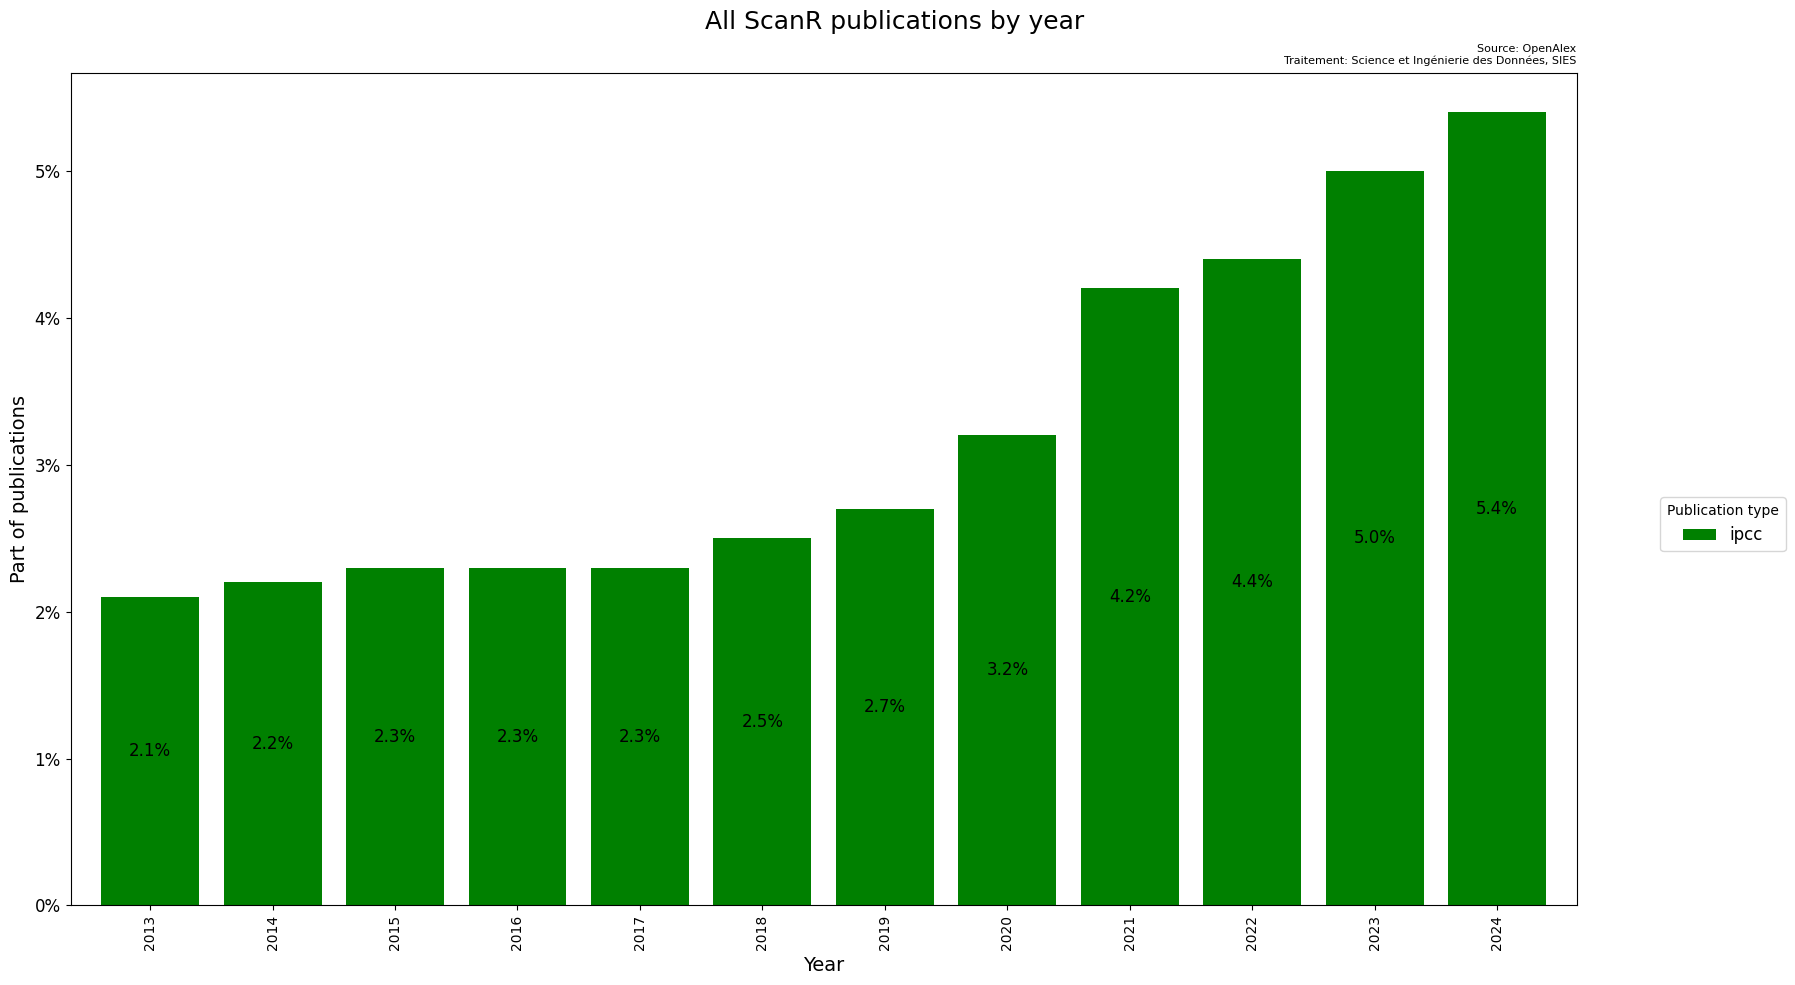

In [17]:
body = {
  "size": 0,
  "track_total_hits": True,
  # "query": {
  #   "bool": {
  #     "filter": {
  #      "exists": {
  #        "field": "year"
  #      }
  #     }
  #   }
  # },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0]}


df = pd.DataFrame.from_dict(data_counts, orient='index', columns=[ 'ipcc'])
df = df.sort_index()

ax = df.head(50).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=['green'])

for i, (index, row) in enumerate(df.head(50).iterrows()): 
    ax.text(i, row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("All ScanR publications by year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

In [18]:
data

{'took': 549,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3225488, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'years': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 2022,
     'doc_count': 317770,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 303756},
       {'key': 'ipcc', 'doc_count': 14014},
       {'key': 'ipcc_adaptation', 'doc_count': 10256},
       {'key': 'ipcc_mitigation', 'doc_count': 2945},
       {'key': 'ipcc_science', 'doc_count': 2347}]}},
    {'key': 2021,
     'doc_count': 264596,
     'predicted_labels': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'not_ipcc', 'doc_count': 253475},
       {'key': 'ipcc', 'doc_count': 11121},
       {'key': 'ipcc_adaptation', 'doc_count': 8010},
   

In [ ]:
#sans les topics
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": {
       "exists": {
         "field": "topics"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2011:
      data_counts[x['key']]=[]
      tot=sum([i['doc_count'] for i in x['predicted_labels']['buckets'] if i['key'] in ['ipcc_science', 'ipcc_adaptation','ipcc_mitigation']])
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation','ipcc_mitigation'])
df = df.sort_index()

list_colors=["#cc566a","#cb6839","#c5aa46","#747734","#62b055","#4bb2ac","#7377cc","#be5dae"]
ax = df.head(50).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=list_colors)

for i, (index, row) in enumerate(df.head(50).iterrows()): 
    if row["ipcc_science"]!=0:
      ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_adaptation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_mitigation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] + row['ipcc_mitigation']/ 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications by Year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

In [ ]:
data

In [ ]:
data['aggregations']['years']['buckets'][0]

In [ ]:
#avec topics
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')
data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      tot=sum([i['doc_count'] for i in x['predicted_labels']['buckets'] if i['key'] in ['ipcc_science', 'ipcc_adaptation','ipcc_mitigation']])
      if 'ipcc_science' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_science'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_adaptation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_adaptation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
      if 'ipcc_mitigation' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc_mitigation'][0]
          data_counts[x['key']].append(round(nb*100/tot,1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0, 0, 0]}
df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc_science', 'ipcc_adaptation','ipcc_mitigation'])
df = df.sort_index()

list_colors=["#cc566a","#cb6839","#c5aa46","#747734","#62b055","#4bb2ac","#7377cc","#be5dae"]
ax = df.head(20).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=list_colors)

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    if row["ipcc_science"]!=0:
      ax.text(i, row['ipcc_science'] / 2, f'{row["ipcc_science"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_adaptation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] / 2, f'{row["ipcc_adaptation"]}%', ha='center', va='center', color='black', size=12)
    if row["ipcc_mitigation"]!=0:
      ax.text(i, row['ipcc_science'] + row['ipcc_adaptation'] + row['ipcc_mitigation']/ 2, f'{row["ipcc_mitigation"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications by Year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      # "must": [
      #   {
      #     "term": {
      #       "externalIds.type": "hal"
      #     }
      #   }
      #  ]#,
      # "must_not": [
      #   {
      #     "term": {
      #       "externalIds.type": "doi"
      #     }
      #   }
      # ]
      #,
      "filter": {
       "exists": {
         "field": "year"
       }
      }
    }
  },
  "aggs": {
    "years": {
      "terms": {
        "field": "year",
        "size": 10000000
      },
      "aggs": {
        "predicted_labels": {
          "terms": {
            "field": "predict_teds.label.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

data_counts={}
for x in data['aggregations']['years']['buckets']:
    if x['doc_count']>=500 and x['key']>=2013:
      data_counts[x['key']]=[]
      if 'ipcc' in [bucket['key'] for bucket in x['predicted_labels']['buckets']]:
          nb=[bucket['doc_count'] for bucket in x['predicted_labels']['buckets'] if bucket['key']=='ipcc'][0]
          data_counts[x['key']].append(round(nb*100/x['doc_count'],1)) 
      else:
          data_counts[x['key']].append(0)
data_counts={key: value for key, value in data_counts.items() if value!= [0]}

df = pd.DataFrame.from_dict(data_counts, orient='index', columns=['ipcc'])
df = df.sort_index()

ax = df.head(20).plot(kind='bar', stacked=True, figsize=(18, 10), width=0.8, color=['green'])

for i, (index, row) in enumerate(df.head(20).iterrows()): 
    ax.text(i, row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=25)
    #ax.text(i, row['not_ipcc'] + row['ipcc'] / 2, f'{row["ipcc"]}%', ha='center', va='center', color='black', size=12)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Part of publications', fontsize=14)
ax.set_yticklabels([f'{tick:.0f}%' for tick in ax.get_yticks()], fontsize=12)

ax.legend(title='Publication type', bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=12)

plt.suptitle("Publications about science by year", size=18)
plt.title('Source: OpenAlex\nTraitement: Science et Ingénierie des Données, SIES', size=8, loc='right')

plt.tight_layout()
plt.show()

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "must_not": [
        {
          "term": {
            "predict_teds.label": "ipcc_science"
          }
        },
        {
          "term": {
            "predict_teds.label": "ipcc_adaptation"
          }
        },
        {
          "term": {
            "predict_teds.label": "ipcc_mitigation"
          }
        }
      ],
      "filter": {
        "exists": {
          "field": "year"
        }
      }
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      }
    }
  }
}
get_from_es(body,'scanr-publications')

top topics ipcc

In [10]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "exists": {
      "field": "topics"
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "topics": {
          "terms": {
            "field": "topics.display_name.keyword",
            "size": 50
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [ ]:
climat_topics=['climate change','marine ecosystems','ecology','ecological','ecosystem','environmental','global methane emissions and impacts','impact of ocean acidification on marine ecosystems','arctic sea ice variability and decline','environmental impact','climate ethics','climate and hydrological cycle','global energy transition','environmental behavior','influence of climate','urban heat islands and mitigation strategies','impact on climate','environmental policies','carbon dioxide capture and storage technologies','soil carbon dynamics and nutrient cycling in ecosystems','sustainable development','environmental governance','atmospheric aerosols and their impacts','marine biogeochemistry and ecosystem dynamics','biodiversity','global flood risk assessment and management','arctic sea ice variability and decline','dynamics of ocean surface waves and wind interaction','aeolian geomorphology and wind erosion dynamics','importance of mangrove ecosystems in coastal protection','water resource management','air pollution','deforestation','rebound effect on energy efficiency and consumption','global drought','landslide hazards and risk assessment','paleoclima']

In [25]:
data['aggregations']['predicted_labels']['buckets'][0]

{'key': 'not_ipcc',
 'doc_count': 1386002,
 'topics': {'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 3556039,
  'buckets': [{'key': 'Territorial Governance and Environmental Participation',
    'doc_count': 22724},
   {'key': 'Impact of Healthcare Legislation on Practice and Ethics',
    'doc_count': 15494},
   {'key': 'Sociology of Public Action and Professional Practices',
    'doc_count': 14768},
   {'key': 'Healthcare Policy Reforms and Inequalities in France',
    'doc_count': 13652},
   {'key': 'Stellar Astrophysics and Exoplanet Studies', 'doc_count': 11865},
   {'key': 'History of Science and Technology', 'doc_count': 11783},
   {'key': 'Formation and Evolution of the Solar System', 'doc_count': 11222},
   {'key': 'Reform of Family Law and Democratic Progress', 'doc_count': 10757},
   {'key': 'Role of Social Innovation in Territorial Development',
    'doc_count': 10029},
   {'key': 'Tectonic and Geochronological Evolution of Orogens',
    'doc_count': 9769},
   {'